In [58]:
from __future__ import print_function

import numpy as np
import pandas as pd

import patsy
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
from collections import defaultdict

%matplotlib inline

In [2]:
df = pd.read_pickle('df_for_analysis.pkl')

In [3]:
df.head()

,title,score_c,rating_c,n_reviews_c,score_u,rating_u,n_reviews_u,director,runtime,studio,audience_rating,month
0,Resident Evil: The Final Chapter,35,0.44,85,51.0,0.59,58527,Paul W.S. Anderson,106.0,Sony Pictures,R,Jan
1,Passengers,31,0.49,229,63.0,0.47,52600,Morten Tyldum,116.0,Columbia Pictures,PG-13,Dec
2,Beauty And The Beast (La Belle Et La Bête),32,0.46,19,53.0,0.66,3681,Christophe Gans,112.0,NaN,PG-13,Jan
3,Fantastic Beasts And Where To Find Them,73,0.68,271,79.0,0.70,84702,David Yates (II),132.0,Warner Bros. Pictures,PG-13,Nov
4,Absolutely Anything,18,0.37,40,31.0,0.54,3080,Terry Jones,85.0,Atlas Distribution,NR,May


In [4]:
df = df[['rating_c', 'n_reviews_c', 'rating_u', 'n_reviews_u', 'director', 'runtime', 'audience_rating', 'month']]

In [5]:
df.head()

,rating_c,n_reviews_c,rating_u,n_reviews_u,director,runtime,audience_rating,month
0,0.44,85,0.59,58527,Paul W.S. Anderson,106.0,R,Jan
1,0.49,229,0.47,52600,Morten Tyldum,116.0,PG-13,Dec
2,0.46,19,0.66,3681,Christophe Gans,112.0,PG-13,Jan
3,0.68,271,0.70,84702,David Yates (II),132.0,PG-13,Nov
4,0.37,40,0.54,3080,Terry Jones,85.0,NR,May


In [6]:
len(df)

1484

In [7]:
len(df.dropna())

1474

In [8]:
df = df.dropna()

### Numerical variables:
* runtime, n_reviews_c, n_reviews_u

n_reviews cannot be used to predict rating in the given context (what to do when you want to make a movie with good reviews), it can only be used to subdivide the data if relevant.

### Categorical variables:
* director, MPAA rating, month


We want to see whether it is possible to predict the rting of a movie, both for critics and for the audience.

# 1. Create overal rating variable?

In [9]:
difference = abs(df.rating_c - df.rating_u)
print(difference.mean())
print(difference.std())

0.06957259158751716
0.07825589793692564


The mean difference is of 7%, with a standard deviation of 8%. Too much variation in the differences, so not a very good idea to just average them.

# 2. Predicting critics ratings

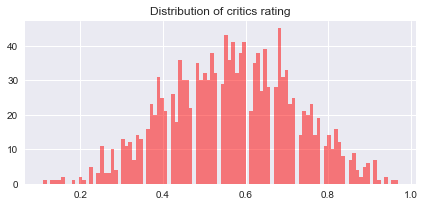

In [10]:
df.rating_c.hist(bins=100, color='r', alpha = 0.5, figsize=(7,3))
plt.title('Distribution of critics rating')

I will not apply any type of transformation on the dependent variable, it has a normal distribution.
Let's look at pairplots:

In [11]:
df_critics = df[['rating_c', 'n_reviews_c', 'runtime', 'director', 'audience_rating', 'month']]

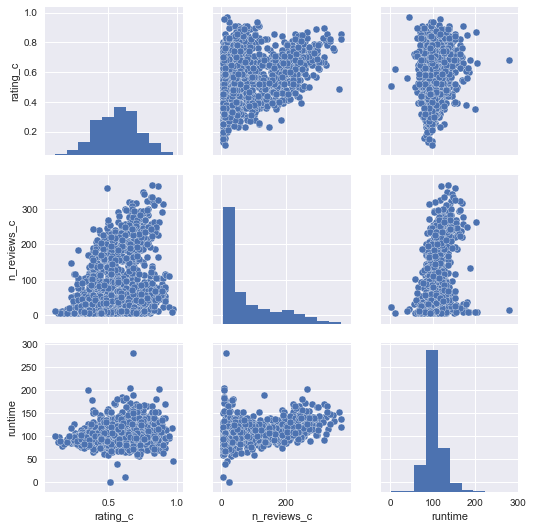

In [12]:
sns.pairplot(df_critics)

Add a constant to the df (statsmodels regression does not add an intercept automatically).

In [13]:
df_critics['constant'] = [1] * len(df.rating_c)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## a. Model based on constant and runtime

                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     27.93
Date:                Sun, 16 Jul 2017   Prob (F-statistic):           1.52e-07
Time:                        19:16:22   Log-Likelihood:                 529.59
No. Observations:                1105   AIC:                            -1055.
Df Residuals:                    1103   BIC:                            -1045.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2243      0.011     19.686      0.0

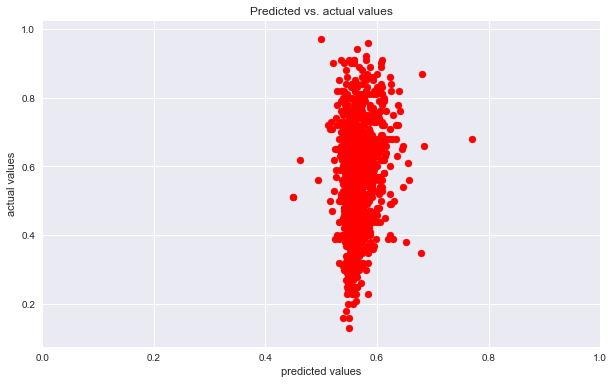

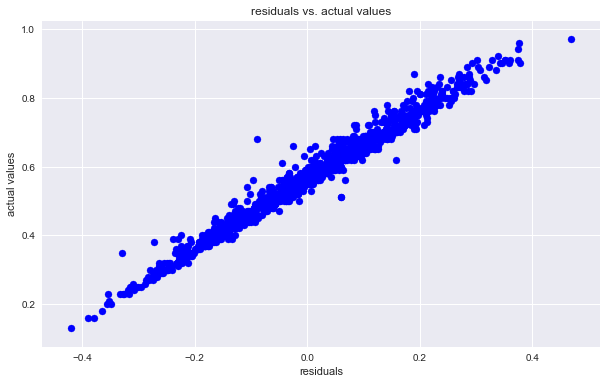

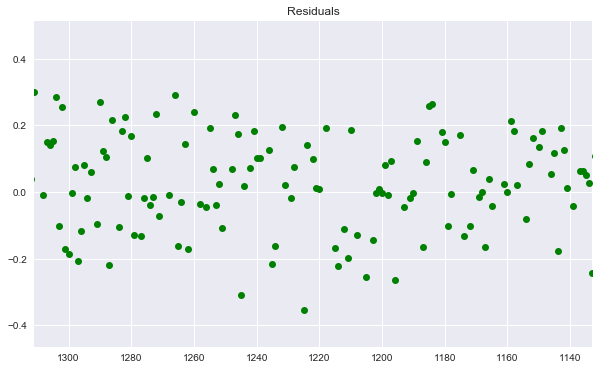

In [14]:
def model_and_plot(y, X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    lsm = smf.ols('y_train ~ X_train', data = X_train)
    lr = lsm.fit()
    print(lr.summary())
    plt.figure(figsize = (10,6))
    plt.xlim(0, 1)
    plt.scatter(lr.predict(), y_train, color = 'r')
    plt.xlabel('predicted values')
    plt.ylabel('actual values')
    plt.title('Predicted vs. actual values')
    plt.show()
    plt.figure(figsize = (10,6))
    plt.scatter(lr.resid, y_train, color = 'b')
    plt.xlabel('residuals')
    plt.ylabel('actual values')
    plt.title('residuals vs. actual values')
    plt.show()
    plt.figure(figsize = (10,6))
    lr.resid.plot(style='o', c='g')
    plt.title('Residuals')
    print()
    return

model_and_plot(df_critics.rating_c, df_critics[['constant', 'runtime']])

Interpretation:

* The predicted values are ± in the interval [0.5-0.7], while the actual values range from 0-1. The shape of the plot indicates lack of relation between rating and runtime.
* For small actual values (< 0.6), the model predicts too small values; for bigger actual values (> 0.6), the model predicts too big values. This confirms that the model always predicts the same value, and that there is no correlation between runtime and rating.
* residuals have random distribution, which is good.

Runtime has a normal distribution but with very high kurtosis. Most data points fall around a hundred minutes, it is almost a constant variable. This is in line with what the regression plots tell us.

Just to see whether making a polynomial model makes sense, let's look at a couple of degrees. I expect to see no better fits.

In [15]:
def mean_sq_error(a, b):
    return np.mean([(a-b)**2 for a,b in zip(a,b)])

def poly_model(X, y, degrees):
    '''both X and y are series (arrays)'''
    df = pd.DataFrame()
    df['X'] = X
    df['y'] = y
    out = {}
    for degree in range(degrees+1):
        df['X'+str(degree)]= X**degree
        independent = df.drop('y', 1)
        X_train, X_test, y_train, y_test = train_test_split(independent, df.y, random_state=42)
        lr = sm.OLS(y_train, X_train).fit()
        MSE_train = mean_sq_error(lr.predict(X_train), y_train)
        MSE_test = mean_sq_error(lr.predict(X_test), y_test)
        R_squared = lr.rsquared
        AIC = lr.aic
        out[degree] = (MSE_train, MSE_test, R_squared, AIC)
    return out

In [16]:
stats = poly_model(df_critics.runtime, df_critics.rating_c, 7)

In [17]:
MSE_trains = [stats[k][0] for  k, v in stats.items()]
MSE_tests = [stats[k][1] for  k, v in stats.items()]
Rs = [stats[k][2] for  k, v in stats.items()]
AICs = [stats[k][3] for  k, v in stats.items()]
degrees = range(8)

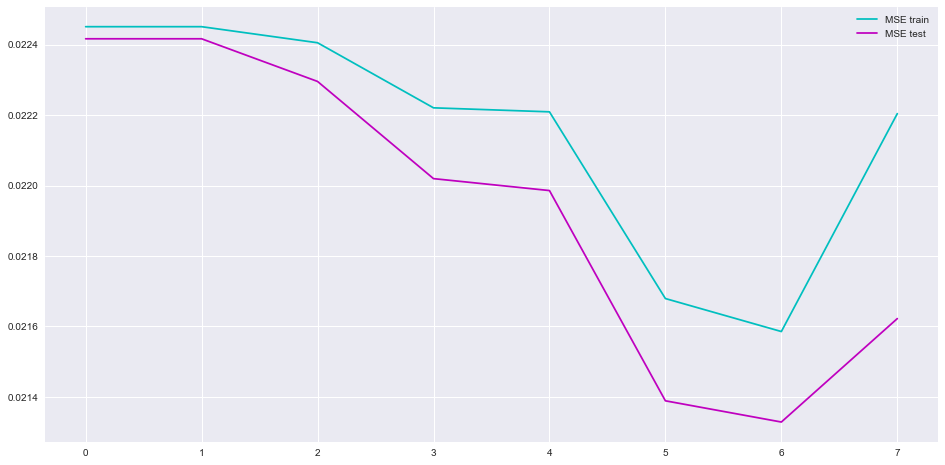

In [18]:
plt.figure(figsize = (16, 8))
plt.plot(degrees, MSE_trains, 'c-', label = 'MSE train')
plt.plot(degrees, MSE_tests, 'm-', label = 'MSE test')
plt.legend()

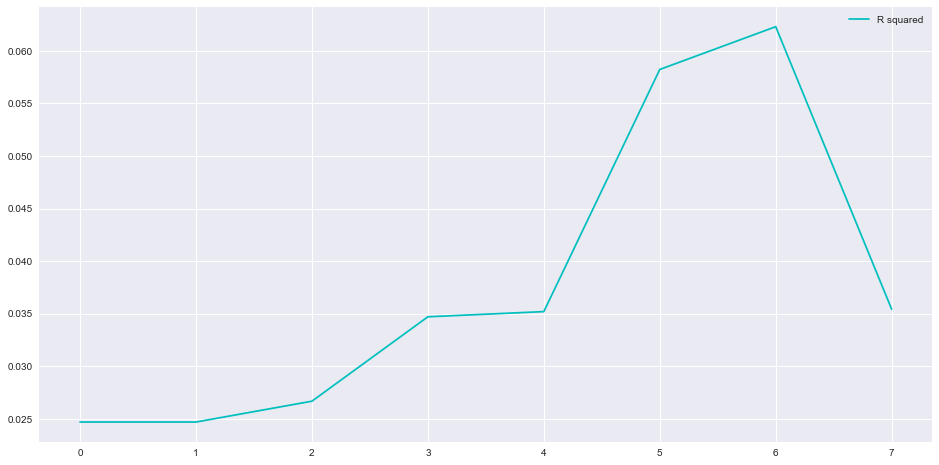

In [19]:
plt.figure(figsize = (16, 8))
plt.plot(degrees, Rs, 'c-', label = 'R squared')
plt.legend()

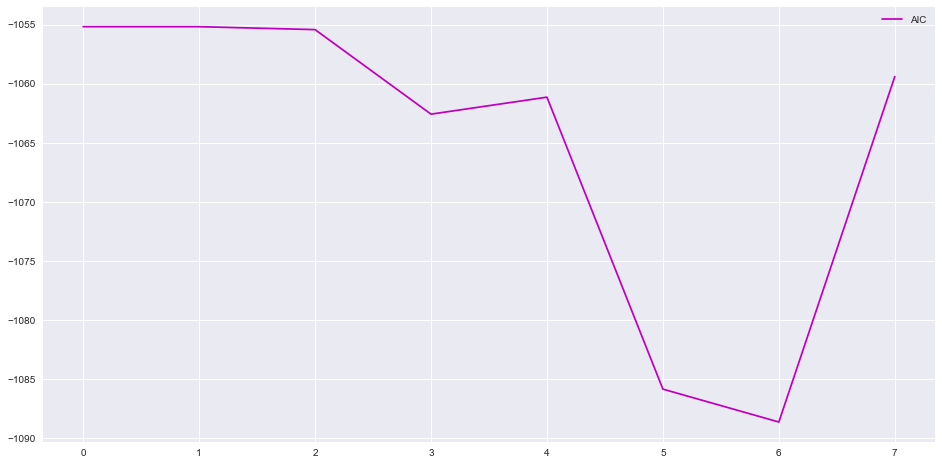

In [20]:
plt.figure(figsize = (16, 8))
plt.plot(degrees, AICs, 'm-', label = 'AIC')
plt.legend()

Actually, a polynomial of the sixth degree seems more adequate. Let's make this model and look at the regression plots:

In [21]:
def poly_test_model(X, y, degrees):
    '''both X and y are series (arrays)'''
    df = pd.DataFrame()
    df['X'] = X
    df['y'] = y
    df['constant'] = [1]*len(X)
    for degree in range(degrees+1):
        df['X'+str(degree)]= X**degree
        independent = df.drop('y', 1)
    X_train, X_test, y_train, y_test = train_test_split(independent, df.y, random_state=42)
    lr = sm.OLS(y_train, X_train).fit()
    print(lr.summary())
    plt.figure(figsize = (10,6))
    plt.xlim(0, 1)
    plt.scatter(lr.predict(), y_train, color = 'r')
    plt.xlabel('predicted values')
    plt.ylabel('actual values')
    plt.title('Predicted vs. actual values')
    plt.show()
    plt.figure(figsize = (10,6))
    plt.scatter(lr.resid, y_train, color = 'b')
    plt.xlabel('residuals')
    plt.ylabel('actual values')
    plt.title('residuals vs. actual values')
    plt.show()
    plt.figure(figsize = (10,6))
    lr.resid.plot(style='o', c='g')
    plt.title('Residuals')
    print()
    return

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     12.16
Date:                Sun, 16 Jul 2017   Prob (F-statistic):           2.87e-13
Time:                        19:16:23   Log-Likelihood:                 551.31
No. Observations:                1105   AIC:                            -1089.
Df Residuals:                    1098   BIC:                            -1054.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.0249      0.007      3.812      0.0

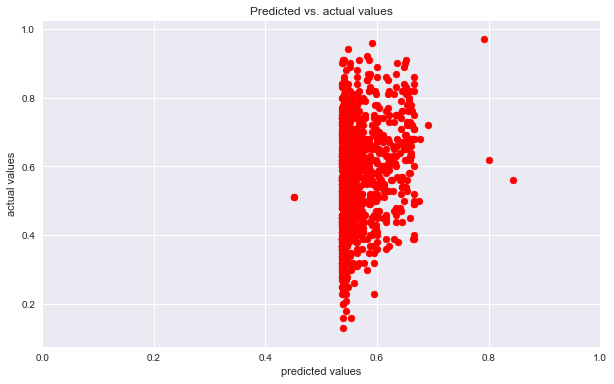

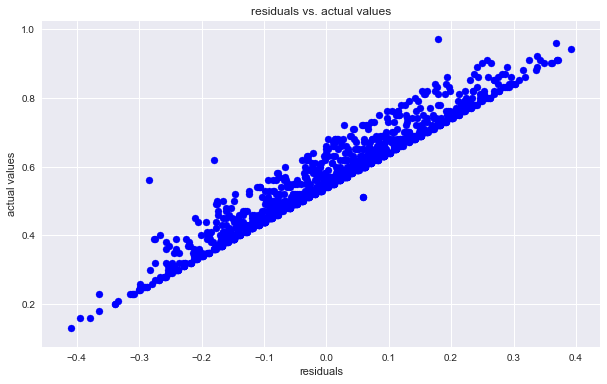

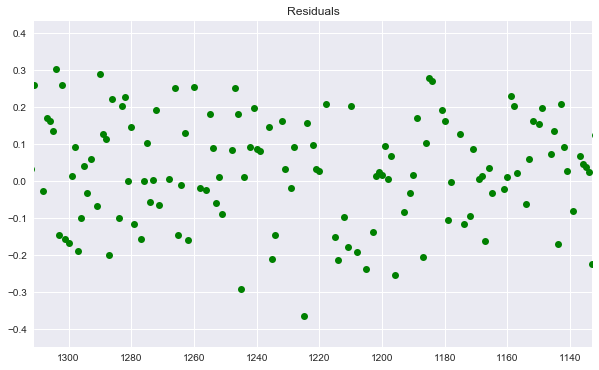

In [22]:
y = df_critics.rating_c
X = df_critics.runtime
poly_test_model(X, y, 6)

Interpretation:
* The predicted values are all \> 0.55. Still not enough correlation. R^2 is slightly bigger though, and so is the adjusted R^2.
* The residuals are still evenly distributed for all predicted values, which confirms the lack of correlation.
* The residuals have a random distribution.

In [23]:
def poly6_model(X, degrees):
    '''takes a series and returns the df containing all the values for each term of the polynomial'''
    df = pd.DataFrame()
    df['X'] = X
    for degree in range(degrees+1):
        df['X'+str(degree)]= X**degree
    return df

In [24]:
xs = poly6_model(df.runtime, 6)
df_critics = df_critics.join(xs)

In [40]:
def scores_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print('Training score: ', lr.score(X_train, y_train))
    print('Testing score: ', lr.score(X_test, y_test))

In [44]:
y = df_critics.rating_c
X = df_critics.drop(['rating_c', 'director', 'audience_rating', 'month'], 1)
X.head()

,n_reviews_c,runtime,constant,X,X0,X1,X2,X3,X4,X5,X6
0,85,106.0,1,106.0,1.0,106.0,11236.0,1191016.0,126247696.0,1.338226e+10,1.418519e+12
1,229,116.0,1,116.0,1.0,116.0,13456.0,1560896.0,181063936.0,2.100342e+10,2.436396e+12
2,19,112.0,1,112.0,1.0,112.0,12544.0,1404928.0,157351936.0,1.762342e+10,1.973823e+12
3,271,132.0,1,132.0,1.0,132.0,17424.0,2299968.0,303595776.0,4.007464e+10,5.289853e+12
4,40,85.0,1,85.0,1.0,85.0,7225.0,614125.0,52200625.0,4.437053e+09,3.771495e+11


In [45]:
scores_train_test(X, y)

Training score:  0.0853497427246
Testing score:  0.105012183495


This model actually does better at predicting than at training. But still, the R^2 is terrible.  
Next steps: there are no other numerical variables (I should have scraped more data), so let's add categorical data to this model.

## b. Model with constant + runtime + director

In [25]:
director = patsy.dmatrix('director',data=df_critics,return_type='dataframe')
with_d = df_critics.join(director).drop('Intercept', axis=1)

In [28]:
def poly6_model(X, degrees):
    '''takes a series and returns the df containing all the values for each term of the polynomial'''
    df = pd.DataFrame()
    df['X'] = X
    for degree in range(degrees+1):
        df['X'+str(degree)]= X**degree
    return df

In [31]:
X = with_d.drop(['n_reviews_c', 'director', 'audience_rating', 'month', 'rating_c'], 1)
y = with_d.rating_c
X.head()

,runtime,constant,X,X0,X1,X2,X3,X4,X5,X6,...,director[T.Woody Allen],director[T.Wuershan],director[T.Wych Kaosayananda],director[T.Yakov Protazanov],director[T.Yorgos Lanthimos],director[T.Yoshitaka Amano],director[T.Yvan Attal],director[T.Zach Helm],director[T.Zack Snyder],director[T.Zhang Zhiliang]
0,106.0,1,106.0,1.0,106.0,11236.0,1191016.0,126247696.0,1.338226e+10,1.418519e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,116.0,1,116.0,1.0,116.0,13456.0,1560896.0,181063936.0,2.100342e+10,2.436396e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,112.0,1,112.0,1.0,112.0,12544.0,1404928.0,157351936.0,1.762342e+10,1.973823e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,132.0,1,132.0,1.0,132.0,17424.0,2299968.0,303595776.0,4.007464e+10,5.289853e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,85.0,1,85.0,1.0,85.0,7225.0,614125.0,52200625.0,4.437053e+09,3.771495e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1738.
Date:                Sun, 16 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:17:32   Log-Likelihood:                 1615.5
No. Observations:                1105   AIC:                            -3221.
Df Residuals:                    1100   BIC:                            -3196.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0469      0.022      2.098

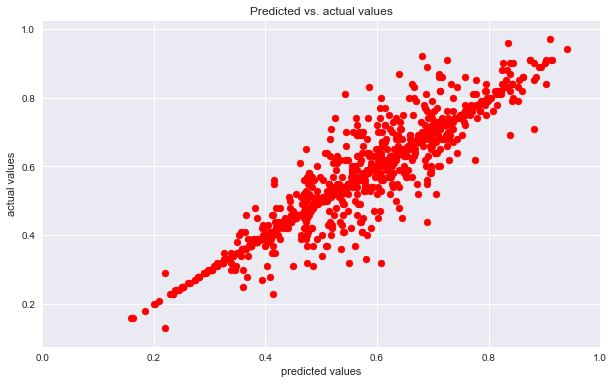

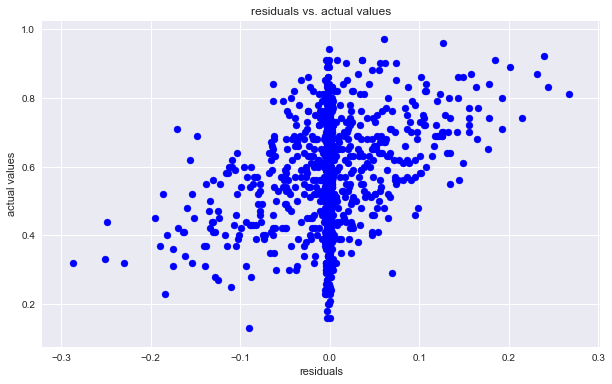

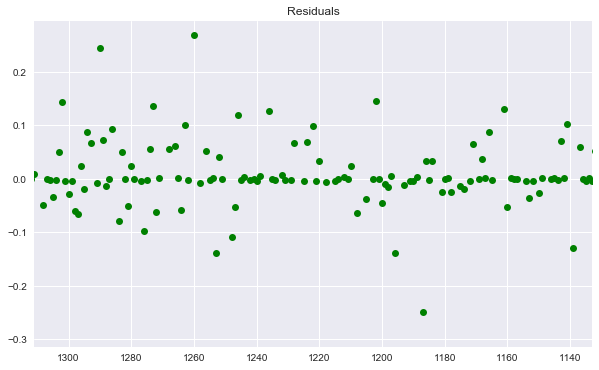

In [32]:
model_and_plot(y, X)

Interpretation:
* the actual vs. predicted plot shows a diagonal line, it is a good model for the training data. R^2 confirms this.
* A lot of residuals are 0. For actual values smaller than 0.6, the model still tends to make too small predictions, for actual values bigger than 0.6, the model tends to make too big predictions.
* Residuals do not have a random distribution, there are a lot of zero residuals. This indicates overfitting. However, the high adjusted R^2 does not indicate overfitting.

Let's see how the model does on the test data. Based on what we see from the plots above, the model probably sucks at predicting the test data.

In [39]:
scores_train_test(X, y)

Training score:  0.864583116106
Testing score:  0.0690409609814


As expected, the model is overfitting.

## c. Model with runtime + rating

In [48]:
rating = patsy.dmatrix('audience_rating',data=df_critics,return_type='dataframe')
with_r = df_critics.join(rating).drop('Intercept', axis = 1)
y = with_r.rating_c
X = with_r.drop(['rating_c', 'director', 'audience_rating', 'month', 'n_reviews_c'], 1)

                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     16.87
Date:                Sun, 16 Jul 2017   Prob (F-statistic):           4.45e-31
Time:                        19:34:09   Log-Likelihood:                 602.40
No. Observations:                1105   AIC:                            -1181.
Df Residuals:                    1093   BIC:                            -1121.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1668      0.035      4.825      

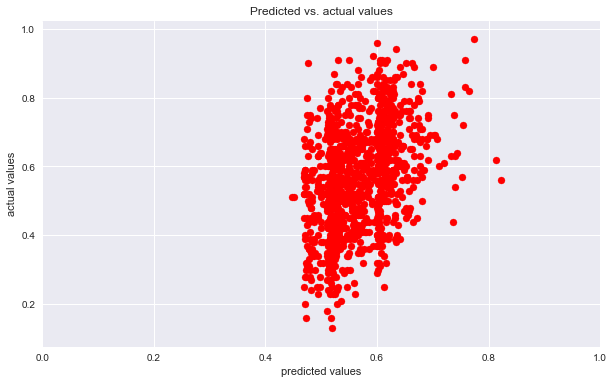

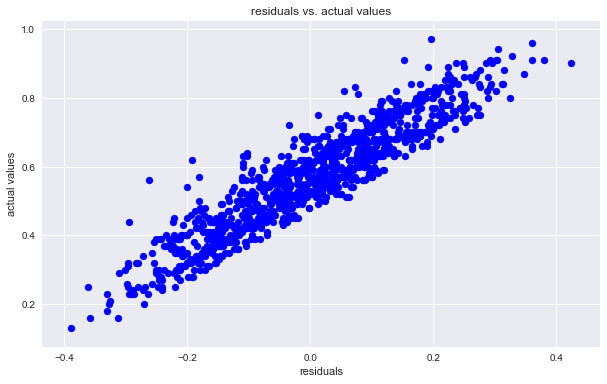

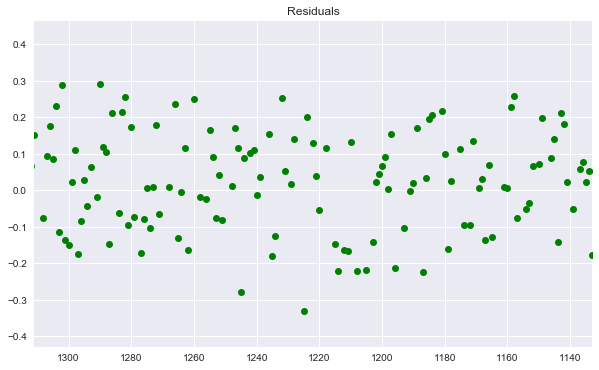

In [49]:
model_and_plot(y, X)

Interpretation:

* Predictions are still very centered. 
* Residuals indicate no correlation.

In [50]:
scores_train_test(X, y)

Training score:  0.145111497857
Testing score:  0.126923308955


The model is terrible.

## d. Model with runtime + month

In [51]:
month = patsy.dmatrix('month',data=df,return_type='dataframe')
with_m = df_critics.join(month).drop('Intercept', axis = 1)
y = with_m.rating_c
X = with_m.drop(['rating_c', 'director', 'audience_rating', 'month', 'n_reviews_c'], 1)

                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     5.247
Date:                Sun, 16 Jul 2017   Prob (F-statistic):           9.35e-11
Time:                        19:37:16   Log-Likelihood:                 556.84
No. Observations:                1105   AIC:                            -1080.
Df Residuals:                    1088   BIC:                            -994.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1355      0.036      3.776      

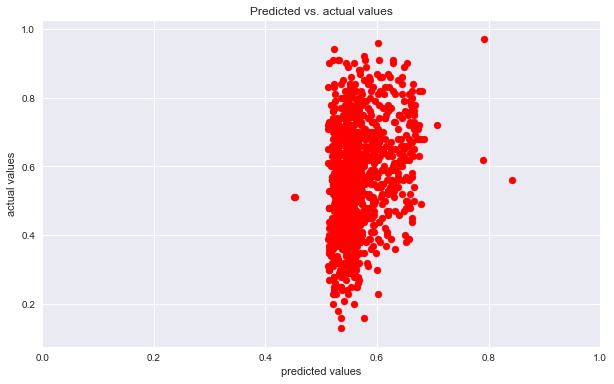

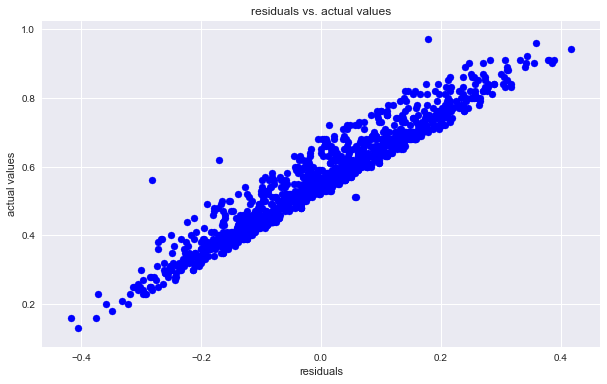

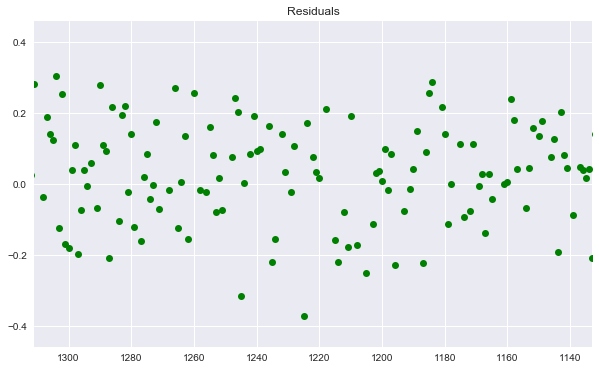

In [52]:
model_and_plot(y, X)

In [53]:
scores_train_test(X, y)

Training score:  0.0716335640096
Testing score:  0.0683834524891


This is even worse...  
__Conclusion so far__: critics rating is very hard to predict. Model is slightly better if runtime is turned into 6th degree polynomial. Including director has huge impact, so it is definitely relevant, but also causes massive overfitting.  
What can we do to avoid overfitting:
* Ridge regularization.
* Select a part of the data: a lot of the directors in the directors column only made one movie in the df. The rating they received for their movie is absolutely unrelated to the rating other directors received. We should focus on directors that made several movies to understand better.

## d. Ridge regularization.

In [55]:
y = with_d.rating_c
X = with_d.drop(['n_reviews_c', 'director', 'audience_rating', 'month', 'rating_c'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

for alpha in np.arange(0.1, 1.1, 0.1):
    print(alpha, Ridge(normalize=True, alpha=alpha).fit(X_train, y_train).score(X_test, y_test))

0.1 0.0949850489311
0.2 0.111806157966
0.3 0.123166154392
0.4 0.130735057908
0.5 0.135630219991
0.6 0.13862229366
0.7 0.140247398447
0.8 0.140883257437
0.9 0.140799552181
1.0 0.140191236794


In [56]:
rid_c = Ridge(normalize=True, alpha = 0.8)
fit_c = rid_c.fit(X_train, y_train)
print(fit_c.score(X_train, y_train))
print(fit_c.score(X_test, y_test))

0.701227503259
0.140883257437


This is the best model we have so far.  
Let's select only the movies that were made by productive directors:

In [68]:
director_counts = defaultdict(int)
for director in df_critics.director:
    director_counts[director]+=1

In [69]:
productive_directors = []
for k, v in director_counts.items():
    if v > 5:
        productive_directors.append(k)

In [70]:
df_prod_dir = df_critics[df_critics.director.isin(productive_directors)]

In [72]:
len(df_prod_dir.dropna())

125

In [77]:
director = patsy.dmatrix('director',data=df_prod_dir,return_type='dataframe')
prod_dir = df_prod_dir.join(director).drop('Intercept', axis=1)
prod_dir.head()

,rating_c,n_reviews_c,runtime,director,audience_rating,month,constant,X,X0,X1,...,director[T.Paul W.S. Anderson],director[T.Peter Jackson],director[T.Ridley Scott],director[T.Robert Stevenson],director[T.Robert Zemeckis],director[T.Roland Emmerich],director[T.Sam Raimi],director[T.Steven Spielberg],director[T.Terry Gilliam],director[T.Tim Burton]
0,0.44,85,106.0,Paul W.S. Anderson,R,Jan,1,106.0,1.0,106.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.43,196,119.0,Roland Emmerich,PG-13,Jun,1,119.0,1.0,119.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36,0.59,206,127.0,Tim Burton,PG-13,Sep,1,127.0,1.0,127.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40,0.57,292,136.0,Bryan Singer,PG-13,May,1,136.0,1.0,136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.68,265,115.0,Steven Spielberg,PG,Jul,1,115.0,1.0,115.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [79]:
y = prod_dir.rating_c
X = prod_dir.drop(['n_reviews_c', 'director', 'audience_rating', 'month', 'rating_c'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

for alpha in np.arange(0.1, 1.1, 0.1):
    print(alpha, Ridge(normalize=True, alpha=alpha).fit(X_train, y_train).score(X_test, y_test))

0.1 0.472769840241
0.2 0.461207037497
0.3 0.447943548775
0.4 0.434005814353
0.5 0.420059179955
0.6 0.406458705259
0.7 0.393383697351
0.8 0.380915906329
0.9 0.369082506948
1.0 0.357880118786


In [80]:
rid_c = Ridge(normalize=True, alpha = 0.1)
fit_c = rid_c.fit(X_train, y_train)
print(fit_c.score(X_train, y_train))
print(fit_c.score(X_test, y_test))

0.459644219132
0.472769840241


We get a model that does not really fit the data, but it predicts as badly as it fits. Let's see which variables are the most relevant:

In [81]:
zipped = zip(fit_c.coef_, X.columns)
sorted(zipped, key = lambda x: x[0], reverse=True)[:7]

[(0.10725968857013982, 'director[T.Ridley Scott]'),
 (0.081888300392889343, 'director[T.Sam Raimi]'),
 (0.054698728433362251, 'director[T.James Cameron]'),
 (0.053868317998234369, 'director[T.David Cronenberg]'),
 (0.05208633425831212, 'director[T.Peter Jackson]'),
 (0.018923404596044142, 'director[T.Tim Burton]'),
 (0.0065039047144905366, 'director[T.Steven Spielberg]')]

According to the critics, this is the top three of Fantasy/Sci-Fi directors:
1. Ridley Scott (Blade runner, Alien, The martian)
2. Sam Raimi (Evil Dead, The jungle book)
3. James Cameron (The terminator, Aliens)

# 3. Predicting audience ratings.

Do the whole thing over again, but with y = ratings_u.